## Find distinguishing properties of modalities

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style='ticks', context='talk', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline



import flotilla

flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects'

folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_modalities/bayesian'

study = flotilla.embark('singlecell_pnm_figure2_modalities_bayesian', flotilla_dir=flotilla_dir)

not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)

/home/obotvinnik/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:810: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/obotvinnik/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())
/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/__init__.py:55: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  load_species_data=load_species_data)


2016-02-12 18:24:37	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities_bayesian/datapackage.json
2016-02-12 18:24:37	Parsing datapackage to create a Study object
2016-02-12 18:25:26	Initializing Study
2016-02-12 18:25:26	Initializing Predictor configuration manager for Study
2016-02-12 18:25:26	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-02-12 18:25:26	Added ExtraTreesClassifier to default predictors
2016-02-12 18:25:26	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-02-12 18:25:26	Added ExtraTreesRegressor to default predictors
2016-02-12 18:25:26	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-02-12 18:25:26	Added GradientBoostingClassifier to default predictors
2016-02-12 18:25:26	Predictor GradientBoostingRegressor is of type <class 'sklearn.

In [2]:
splicing_singles_no_outliers = study.splicing.singles.ix[not_outliers]


### Modality bar graph of events inconsistent with pooled

In [4]:
modalities_inconsistent = study.percent_pooled_inconsistent(
    feature_subset=study.supplemental.modalities_tidy.event_id.unique())

/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/data_model/splicing.py:218: FutureWarning: diff is deprecated. Use difference instead
  not_measured_in_pooled = singles.columns.diff(pooled.columns)


In [5]:
pooled_inconstent_folder = '{}/pooled_inconsistent_delta_psi'.format(folder)
! mkdir $pooled_inconstent_folder

mkdir: cannot create directory `/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_modalities/bayesian/pooled_inconsistent_delta_psi': File exists


In [6]:
from flotilla.visualize.generic import cdfplot

singles_grouped = study.splicing.singles.groupby(study.sample_id_to_phenotype)
pooled_grouped = study.splicing.pooled.groupby(study.sample_id_to_phenotype)

bins = np.arange(0, 1.05, 0.05)

min_difference = 0.2

pooled_inconsistent_dir = '{}/pooled_inconsistent'.format(folder)
! mkdir $pooled_inconsistent_dir

mean_diff_dfs = []

for (phenotype, modality), df in study.supplemental.modalities_tidy.groupby(['phenotype', 'modality']):
    singles = singles_grouped.get_group(phenotype).ix[:, df.event_id].dropna(how='all',axis=1)
    pooled = pooled_grouped.get_group(phenotype).ix[:, df.event_id].dropna(how='all', axis=1)
    
    singles, pooled = singles.align(pooled, axis=1, join='inner')
    mean_difference = pooled.apply(lambda x: singles.subtract(x, axis=1).abs().mean(axis=0), axis=1)
    
    mean_diff_df = mean_difference.unstack().reset_index()
    mean_diff_df['phenotype'] = phenotype
    mean_diff_df['modality'] = modality
    mean_diff_dfs.append(mean_diff_df)
    
    events = mean_difference.columns[(mean_difference > min_difference).any(axis=0)]
#     for event in events:
#         gene_name = study.splicing.feature_data.gene_name[event]
#         study.plot_event(event, sample_subset='~outlier')
#         fig = plt.gcf()
#         fig.savefig('{}/{}_{}_{}_{}.pdf'.format(
#                 pooled_inconsistent_dir, modality, phenotype, gene_name, event))
    
mean_diff_df = pd.concat(mean_diff_dfs)
mean_diff_df = mean_diff_df.rename(columns={0: 'mean diff', 'level_0': 'event_id', 
                                            'level_1':'pooled_id'})

mkdir: cannot create directory `/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_modalities/bayesian/pooled_inconsistent': File exists


In [7]:
from anchor import MODALITY_ORDER, MODALITY_PALETTE, MODALITY_TO_COLOR

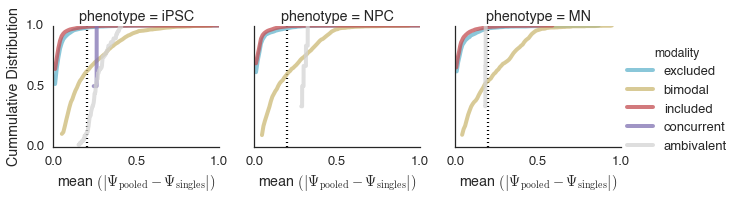

In [8]:
g = sns.FacetGrid(mean_diff_df, col='phenotype', col_order=study.phenotype_order, hue='modality', size=3,
                  hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE, legend_out=True)
g.map(cdfplot, 'mean diff', log=False, alpha=0.75, linewidth=4)

g.set(ylim=(0, 1))
for ax in g.axes.flat:
    ax.locator_params(nbins=4)
    if ax.is_first_col():
        ax.set_ylabel('Cummulative Distribution')
    xmin, xmax, ymin, ymax = ax.axis()
    ax.vlines(min_difference, ymin, ymax, linestyle='dotted')
    ax.set(xlim=(0, xmax), 
           xlabel=r'mean $\left(\left|\Psi_{\mathrm{pooled}} - \Psi_{\mathrm{singles}}\right|\right)$')
g.fig.tight_layout()
g.add_legend();
g.savefig('{}/modality_pooled_inconsistent_cdf.pdf'.format(pooled_inconstent_folder))

In [9]:
mean_diff_df_01 = mean_diff_df.loc[mean_diff_df['mean diff'] >= min_difference]

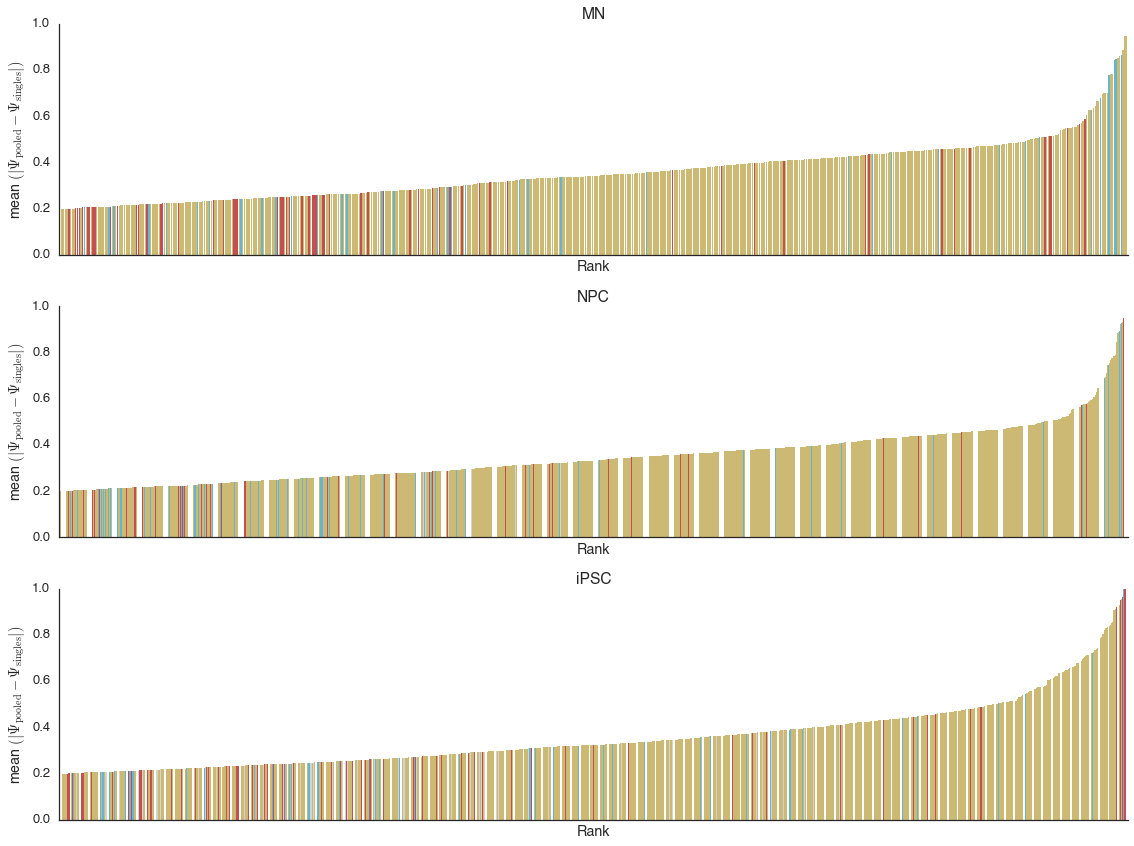

In [10]:
fig, axes = plt.subplots(figsize=(16, 12), nrows=3)

ylabel = r'mean $\left(\left|\Psi_{\mathrm{pooled}} - \Psi_{\mathrm{singles}}\right|\right)$'

for ax, (phenotype, phenotype_df) in zip(axes, mean_diff_df_01.groupby('phenotype')):
    phenotype_df['mean diff rank'] = phenotype_df['mean diff'].rank(method='first')
    for modality, modality_df in phenotype_df.groupby('modality'):
        x = modality_df['mean diff rank']
        y = modality_df['mean diff']
        color = MODALITY_TO_COLOR[modality]
        ax.bar(x, y, color=color, linewidth=0)
    xmax = phenotype_df['mean diff rank'].max() + 1
    
    ax.set(xlim=(0, xmax), xlabel='Rank', title=phenotype, ylabel=ylabel, xticks=[])
    sns.despine()
#     df = df.sort_values('mean diff')
fig.tight_layout()
fig.savefig('{}/delta_psi_ranked_barplot.pdf'.format(pooled_inconstent_folder))

In [11]:
study.supplemental.splicing_singles_vs_pooled = mean_diff_df

In [12]:
mean_diff_df.head()

,event_id,pooled_id,mean diff,phenotype,modality
0,exon:chr12:56554027-56554104:+@exon:chr12:5655...,M2_05,0.183825,MN,ambivalent
1,exon:chr12:56554027-56554104:+@exon:chr12:5655...,M2nd_13,0.180420,MN,ambivalent
2,exon:chr12:56554027-56554104:+@exon:chr12:5655...,M2nd_21,0.181960,MN,ambivalent
0,exon:chr10:103360960-103361093:+@exon:chr10:10...,M2_05,0.037037,MN,bimodal
1,exon:chr10:103360960-103361093:+@exon:chr10:10...,M2nd_13,0.037037,MN,bimodal


In [13]:
mean_diff_df02 = mean_diff_df.loc[mean_diff_df['mean diff'] > 0.2]
mean_diff_df02.shape

(2586, 5)

In [14]:
mean_diff_02_modalities = mean_diff_df02.groupby('modality').size()
mean_diff_02_modalities

modality
ambivalent      65
bimodal       2159
concurrent       2
excluded       159
included       201
dtype: int64

In [15]:
mean_diff_02_modalities.sum()

2586

In [16]:
mean_diff_02_modalities_percentage = 100*mean_diff_02_modalities/mean_diff_02_modalities.sum()
mean_diff_02_modalities_percentage.head()

modality
ambivalent     2.513534
bimodal       83.488012
concurrent     0.077340
excluded       6.148492
included       7.772622
dtype: float64

In [22]:
percent_col = '%'.format()
x_col = 'of {} events with $|\Delta\Psi| > 0.2$'.format(mean_diff_02_modalities.sum())

mean_diff_02_modalities_percentage_df = mean_diff_02_modalities_percentage.reset_index()
mean_diff_02_modalities_percentage_df = mean_diff_02_modalities_percentage_df.rename(
    columns={0: percent_col})
mean_diff_02_modalities_percentage_df['x'] = x_col
mean_diff_02_modalities_percentage_df

,modality,%,x
0,ambivalent,2.513534,of 2586 events with $|\Delta\Psi| > 0.2$
1,bimodal,83.488012,of 2586 events with $|\Delta\Psi| > 0.2$
2,concurrent,0.077340,of 2586 events with $|\Delta\Psi| > 0.2$
3,excluded,6.148492,of 2586 events with $|\Delta\Psi| > 0.2$
4,included,7.772622,of 2586 events with $|\Delta\Psi| > 0.2$


In [23]:
sns.set(style='ticks', context='paper')

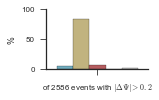

In [24]:
g = sns.factorplot(hue='modality', hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE,
               x='x', y=percent_col, size=1.5, legend=False, aspect=1.5,
               data=mean_diff_02_modalities_percentage_df, kind='bar')
g.set(xlabel='')
for ax in g.axes.flat:
    ax.locator_params(nbins=4, axis='y')
g.fig.tight_layout()
g.savefig('{}/percent_delta_psi_greater_02_modality.pdf'.format(pooled_inconstent_folder))

In [19]:
# mean_diff_percentage = mean_diff_df.groupby(['phenotype', 'modality']).apply(
#     lambda x: 100.*(x['mean diff'] > min_difference).sum()/x.shape[0])
# mean_diff_percentage = mean_diff_percentage.reset_index()
# mean_diff_percentage = mean_diff_percentage.rename(columns={0: 'Percent single-cell events\ninconsistent with pooled'})
# g = sns.factorplot(x='phenotype', y='Percent single-cell events\ninconsistent with pooled', hue='modality',
#                    data=mean_diff_percentage, kind='bar', size=3, aspect=1.25, legend=False, **modality_factorplot_kws)
# for ax in g.axes.flat:
#     ax.locator_params('y', nbins=4)
# g.fig.tight_layout()
# g.add_legend();

# g.savefig('{}/modality_pooled_inconsistent_percentage.pdf'.format(folder))